# How to (LS)GAN galaxy clusters

In this tutorial we will learn how to implement a Least-Squares GAN using tensorflow.keras. Step-by-step, we are going to: 

1) Explore images of galaxy clusters as measured at X-ray wavelengths

2) Prepare our data for GAN training

3) Set up both the generator and discriminator model

4) Generate the noise that the GAN will use to create images from

5) Train our LSGAN model and explore possible improvements


### Data
The data we are using were generated (Comparat et al. 2020, https://arxiv.org/abs/2008.08404) to simulate exptected imaging of galaxy clusters at X-ray wavelengths for the eROSITA telescope (https://erosita.mpe.mpg.de/).


### General remarks
Using GPU is recommended for this task, nevertheless, it should run albeit slowly on CPU.

In [1]:
# some packages that we will need
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib import cm
from tensorflow import keras
import scipy

## 1) Load data from Sample File with Galaxy Cluster Images

The data file prepared is a smaller subset of the full data available.

Question: What do you notice about the data? What are minima / maxima? What needs to be done in order to be able to input it to a network?

No. of images:  3867


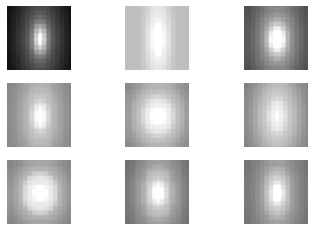

In [2]:
data = np.load('imagedata_cuts.npy')
N_image = data.shape[0]
print('No. of images: ', N_image)

# let's have a look at some images
i=0
n_axis = 3
n_samples = n_axis*n_axis
    
for i in range(n_samples):
    plt.subplot(n_axis, n_axis, 1 + i)
    plt.axis('off')
    #print(data[np.random.randint(0,1000)].shape)
    plt.imshow(data[np.random.randint(0,1000)], cmap='gray',norm=cm.colors.LogNorm(vmin=3e-7,vmax=0.025))
plt.show()

## 2) Rescale images

### Task: 
Normalise the images in such a way they can be useful for network training. 

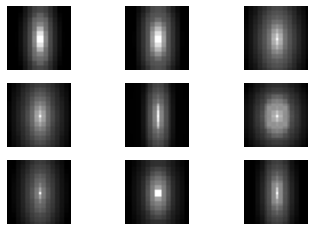

In [3]:
j=0 
scale = True 
resizedimages = []
eps = 1e-14
im_size = 28

# we chose a minmax log-scaling here
while j< N_image:
    img = data[j]+eps
    if scale == True:
       img = -np.log(img)
       mincrop = np.min(img)
       maxcrop = np.max(img)
       if (maxcrop-mincrop)!=0.0:
           img = 1.0-1.0*(img-mincrop)/(maxcrop-mincrop)
    imgsave = np.array(img)
    del(img)
    resizedimages.append(imgsave)
    j=j+1
    
# let's have a look again at images rescaled to [0,1]
i=0
for i in range(n_samples):
    plt.subplot(n_axis, n_axis, 1 + i)
    plt.axis('off')
    #print(data[np.random.randint(0,1000)].shape)
    plt.imshow(resizedimages[np.random.randint(0,1000)], cmap='gray')
plt.show()

## 3a) Generator model

### Task:
Set up a generator model based on convolutional layers that is suitable to generate images of the dimension desired.

In [4]:
def generator_model(latent_dim):
    model = keras.models.Sequential()
    # start with 7x7 image
    n_nodes = latent_dim * 7 * 7
    model.add(keras.layers.Dense(n_nodes, input_dim=latent_dim))
    model.add(keras.layers.LeakyReLU(alpha=0.2))
    model.add(keras.layers.Reshape((7, 7, latent_dim)))
    # upsample to 14x14
    model.add(keras.layers.Conv2DTranspose(latent_dim, (4,4), strides=(2,2), padding='same'))
    model.add(keras.layers.LeakyReLU(alpha=0.2))
    # upsample to 28x28
    model.add(keras.layers.Conv2DTranspose(latent_dim, (4,4), strides=(2,2), padding='same'))
    model.add(keras.layers.LeakyReLU(alpha=0.2))
    model.add(keras.layers.Conv2D(1, (7,7), activation='sigmoid', padding='same'))
    model.add(keras.layers.Activation('tanh'))
    return model

In [5]:
latent_size = 128
g = generator_model(latent_size)
g.summary()
# the generator is compiled as part of the full GAN model later
#g_opt = keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5)
#g.compile(loss='mse', optimizer=g_opt, metrics=['accuracy'])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6272)              809088    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 6272)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 128)       262272    
____

## 3b) Discriminator model

### Task:
Set up a discriminator model based on convolutional layers that is suitable to evaluate images of the desired dimension. Choose a final activation function that makes sense for a mean squared loss. 

In [6]:
def discriminator_model(in_shape=(im_size,im_size,1)):
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(keras.layers.LeakyReLU(alpha=0.2))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    model.add(keras.layers.LeakyReLU(alpha=0.2))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1, activation='linear'))
    opt = keras.optimizers.Adam(lr=0.00001, beta_1=0.5)
    model.compile(loss='mse', optimizer=opt, metrics=['accuracy'])
    return model

In [7]:
# check the model summary
d = discriminator_model()
d.summary()
# compile the discriminator
d_opt = keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5)
d.compile(loss='mse', optimizer=d_opt, metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)             

## 4) Noise and sample generation

### Task
Generate random noise to be used as a generator input. Prepare for the generation of real and fake samples. 

In [8]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = np.random.randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input
 
# use the generator to generate n fake examples
# with class labels 0 for generated images)
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # add class labels (0)
    y = np.zeros((n_samples, 1))
    return X, y

# draw and label real sample
def generate_real_samples(dataset, n_samples):
    # choose random instances
    n_samples = int(n_samples)
    lendata = int(len(dataset))
    ix = np.random.randint(0, lendata, n_samples)
    dataset = np.array(dataset)
    # retrieve selected images
    X = dataset[ix]
    X = np.expand_dims(X, axis = -1)
    # generate 'real' class labels (1)
    y = np.ones((n_samples, 1))
    return X, y

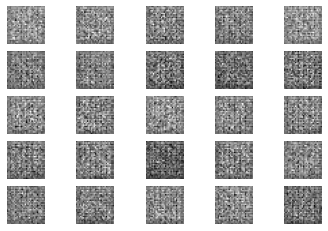

(28, 28)


In [9]:
# generate and plot generated noise samples
g_model = generator_model(latent_size)

n_samples = 25
X, _ = generate_fake_samples(g_model, latent_size, n_samples)

for i in range(n_samples):
    plt.subplot(5, 5, 1 + i)
    plt.axis('off')
    plt.imshow(X[i, :, :, 0], cmap='gray_r')
plt.show()
print(X[1,:,:,0].shape)

## 5) GAN model and training

### Task
Define the GAN, combining the discriminator and the generator model, and choosing the appropriate loss again for our LSGAN. 

In [10]:
def define_lsgan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = keras.models.Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = keras.optimizers.Adam(lr=0.002, beta_1=0.5)
    model.compile(loss='mse', optimizer=opt)
    return model

In [11]:
# auxiliaries

def save_plot(examples, epoch, n=2):
    # plot images
    for i in range(n * n):
        # define subplot
        plt.subplot(n, n, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(examples[i, :, :, 0], cmap='gray')
    # save plot to file
    filename = 'generated_plot_e%03d.png' % (epoch+1)
    plt.savefig(filename)
    plt.close()

def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # save plot
    save_plot(x_fake, epoch)
    # save the generator model tile file
    filename = 'generator_model_n%03d.h5' % (epoch + 1)
    g_model.save(filename)

In [12]:
# training function
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=20, n_batch=500):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    
    for i in range(n_epochs):
        
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            
            # create training set for the discriminator
            X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
            # update discriminator model weights
            d_loss, _ = d_model.train_on_batch(X, y)
            
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create labels for the fake samples 
            y_gan = np.ones((n_batch, 1))
            
            # update (train) the generator
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            
            # summarize loss on this batch
            print('epoch %d, batch %d/%d, loss d=%.3f, loss g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
        save_plot(X_fake, i)

### Task
Judge when the training starts to converge. What can and should be improved in order to create better images?

In [13]:
latent_dim = 100
# create the discriminator
d_model = discriminator_model()
# create the generator
g_model = generator_model(latent_dim)
# create the gan
gan_model = define_lsgan(g_model, d_model)

# load image data
dataset = np.array(resizedimages)

# train model
n_epochs = 10
train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs)

epoch 1, batch 1/7, loss d=0.446, loss g=0.877
epoch 1, batch 2/7, loss d=0.439, loss g=0.842
epoch 1, batch 3/7, loss d=0.444, loss g=0.793
epoch 1, batch 4/7, loss d=0.453, loss g=0.765
epoch 1, batch 5/7, loss d=0.454, loss g=0.727
epoch 1, batch 6/7, loss d=0.456, loss g=0.707
epoch 1, batch 7/7, loss d=0.456, loss g=0.677
epoch 2, batch 1/7, loss d=0.458, loss g=0.663
epoch 2, batch 2/7, loss d=0.454, loss g=0.658
epoch 2, batch 3/7, loss d=0.460, loss g=0.621
epoch 2, batch 4/7, loss d=0.456, loss g=0.627
epoch 2, batch 5/7, loss d=0.459, loss g=0.633
epoch 2, batch 6/7, loss d=0.460, loss g=0.610
epoch 2, batch 7/7, loss d=0.461, loss g=0.582
epoch 3, batch 1/7, loss d=0.454, loss g=0.614
epoch 3, batch 2/7, loss d=0.460, loss g=0.566
epoch 3, batch 3/7, loss d=0.469, loss g=0.535
epoch 3, batch 4/7, loss d=0.468, loss g=0.564
epoch 3, batch 5/7, loss d=0.472, loss g=0.514
epoch 3, batch 6/7, loss d=0.476, loss g=0.508
epoch 3, batch 7/7, loss d=0.473, loss g=0.481
epoch 4, batc

### Task
Have a look at images generated with your trained model. Change the training function to pass on loss curves and plot these. 

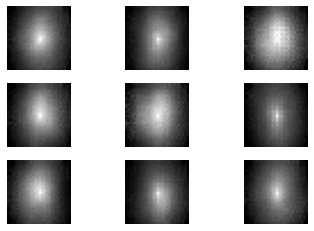

In [16]:
# generate samples for model just trained OR saved model
n_axis = 3
n_samples = n_axis*n_axis
latent_dim =100
do_load = True
if do_load:
    latent_dim = 10000
    g_model = keras.models.load_model('lsgan.h5')
    # or load a previous old model of yours here, e.g.:
    #g_model = keras.models.load_model('generator_model_n020.h5')
X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
# plot the generated samples
for i in range(n_samples):
    # define subplot
    plt.subplot(n_axis, n_axis, 1 + i)
    # turn off axis labels
    plt.axis('off')
    plt.imshow(X[i, :, :, 0], cmap='gray')
plt.show()

### Bonus: 

Compare with the LSGAN based on the model 'lsgan.h5' provided. Crucial changes made in order to improve the trained model include: a) larger training sample, b) larger latent space, c) adaptive learning rate, d) smaller batch size, e) more epochs. 